# Initialization

In [230]:
import pandas as pd
import re
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
seventies_df = pd.read_csv("DFs/united_seventies.csv")

In [9]:
print(seventies_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 22 columns):
name                   497 non-null object
artist                 497 non-null object
artist_first_letter    497 non-null object
artist_songs_ratio     497 non-null float64
year                   497 non-null int64
song_popularity        497 non-null int64
artist_popularity      497 non-null int64
duration_ms            497 non-null int64
key                    497 non-null int64
time_signature         497 non-null int64
acousticness           497 non-null float64
danceability           497 non-null float64
energy                 497 non-null float64
instrumentalness       497 non-null float64
loudness               497 non-null float64
speechiness            497 non-null float64
valence                497 non-null float64
tempo                  497 non-null float64
genres                 497 non-null object
views                  497 non-null int64
old_chart_position     497 non-nu

## checking for number of nominee songs per artist

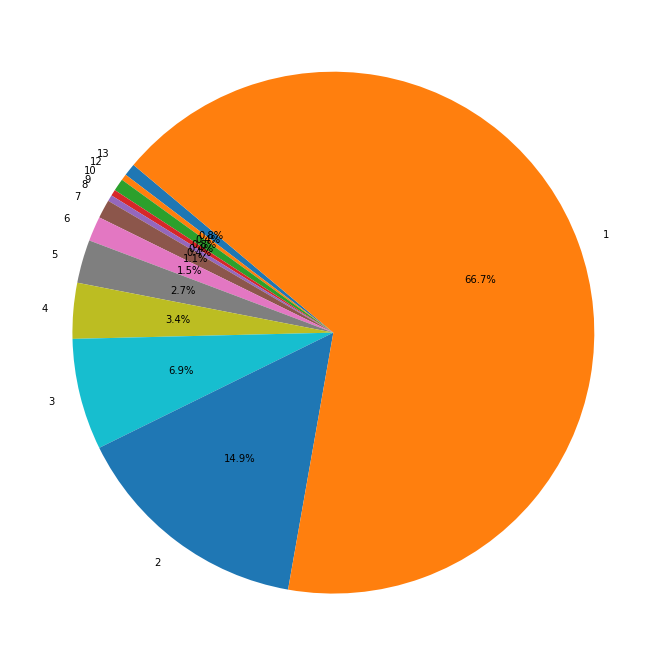

In [487]:
artist_value_counts = seventies_df.artist.value_counts()
artist_count = pd.DataFrame(columns = ['key', 'count'], dtype=int)
for orig_value in artist_value_counts:
    if orig_value in pd.Series(artist_count['count'].astype('int')):
        artist_count.loc[artist_count['key'] == orig_value, 'count'] = artist_count.at[orig_value, 'count']+1
    else:
        artist_count.loc[orig_value] = [orig_value, 1]
plt.figure(figsize=(12,12))
plt.pie(artist_count['count'], labels=artist_count['key'],
autopct='%1.1f%%', startangle=140)
#plt.axis('equal')
plt.show()

It seems like two thirds of the songs were by artists who inserted only one song to the nominee list. On the other hand, there are five artists who entered more than 10 songs to the nominee list. Let's find out who they are:

In [458]:
#print(seventies_df.artist.value_counts()[seventies_df.artist.value_counts() > 9])

popular_artists_df = []
for index in seventies_df.artist.value_counts()[seventies_df.artist.value_counts() > 9].index:
    artist = {}
    artist['name'] = index
    artist['nominee_songs'] = seventies_df.artist.value_counts()[index]
    artist['entered_songs'] = seventies_df.loc[seventies_df['new_chart_location'] > 0].artist.value_counts()[index]
    artist['success_rate'] = artist['entered_songs'] / artist['nominee_songs']
    popular_artists_df.append(artist)
popular_artists_df = pd.DataFrame(popular_artists_df)
display(popular_artists_df)

,name,nominee_songs,entered_songs,success_rate
0,Stevie Wonder,13,1,0.076923
1,David Bowie,13,5,0.384615
2,Elton John,12,6,0.500000
3,Queen,10,7,0.700000
4,ABBA,10,7,0.700000


## Creating a new DataFrame of the songs grouped by artist

In [488]:
grouped_by_artist = seventies_df.groupby('artist')
artists_df = []
for index in seventies_df.artist.value_counts().index:
    artist = {}
    artist['name'] = index
    artist['candidate_songs'] = seventies_df.artist.value_counts()[index]
    artist_group = grouped_by_artist.get_group(index)
    artist['first_letter'] = artist_group['artist_first_letter'].values[0]
    artist['popularity'] = artist_group['artist_popularity'].values[0]
    artist['avg_song_pop'] = artist_group['song_popularity'].mean()
    artist['max_song_pop'] = artist_group['song_popularity'].max()
    artist['min_song_pop'] = artist_group['song_popularity'].min()
    artist['genres'] = {}
    for song in artist_group['genres']:
        for song_genre in song.split(","):
            if len(re.findall(r"'([^']*)'", song_genre))>0:
                if re.findall(r"'([^']*)'", song_genre)[0] not in artist['genres'].keys():
                    artist['genres'][re.findall(r"'([^']*)'", song_genre)[0]] = 1
                else:
                    artist['genres'][re.findall(r"'([^']*)'", song_genre)[0]] += 1
    artist['sum_views'] = artist_group['views'].sum()
    artist['avg_views'] = artist_group['views'].mean()
    artist['avg_old_chart'] = artist_group.where(artist_group.old_chart_position > 0).old_chart_position.mean()
    artist['count_old_chart'] = artist_group.where(artist_group.old_chart_position > 0).old_chart_position.count()
    artist['avg_new_chart'] = artist_group.where(artist_group.new_chart_location > 0).new_chart_location.mean()
    artist['count_new_chart'] = artist_group.where(artist_group.new_chart_location > 0).new_chart_location.count()
    artists_df.append(artist)
artists_df = pd.DataFrame(artists_df)
print(artists_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 14 columns):
name               261 non-null object
candidate_songs    261 non-null int64
first_letter       261 non-null object
popularity         261 non-null int64
avg_song_pop       261 non-null float64
max_song_pop       261 non-null int64
min_song_pop       261 non-null int64
genres             261 non-null object
sum_views          261 non-null int64
avg_views          261 non-null float64
avg_old_chart      50 non-null float64
count_old_chart    261 non-null int64
avg_new_chart      56 non-null float64
count_new_chart    261 non-null int64
dtypes: float64(4), int64(7), object(3)
memory usage: 25.6+ KB
None


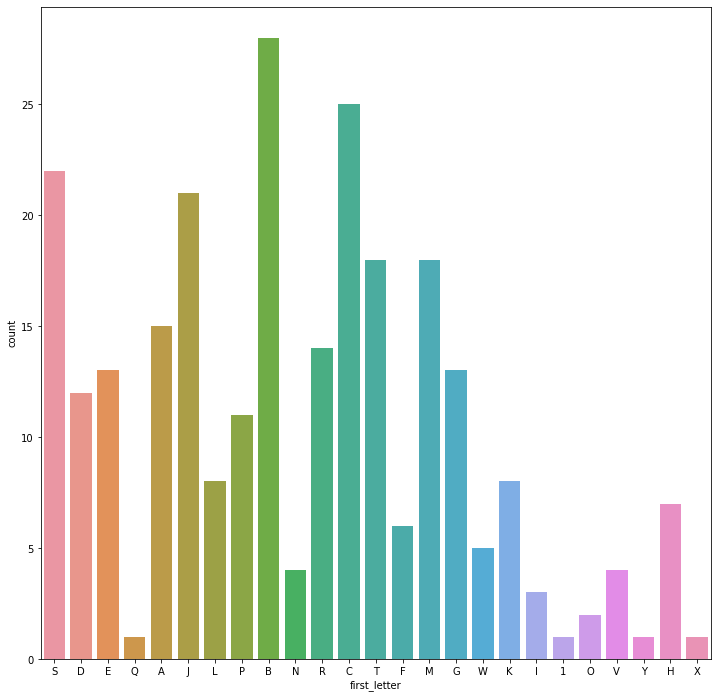

In [489]:
plt.figure(figsize=(12,12))
sns.countplot(x="first_letter", data=artists_df)

It seems like plenty of songs nomineed are from artists starting with 'B', 'T', or 'S'. Now I am looking for interaction between the artist's popularity and the number of nominee songs.

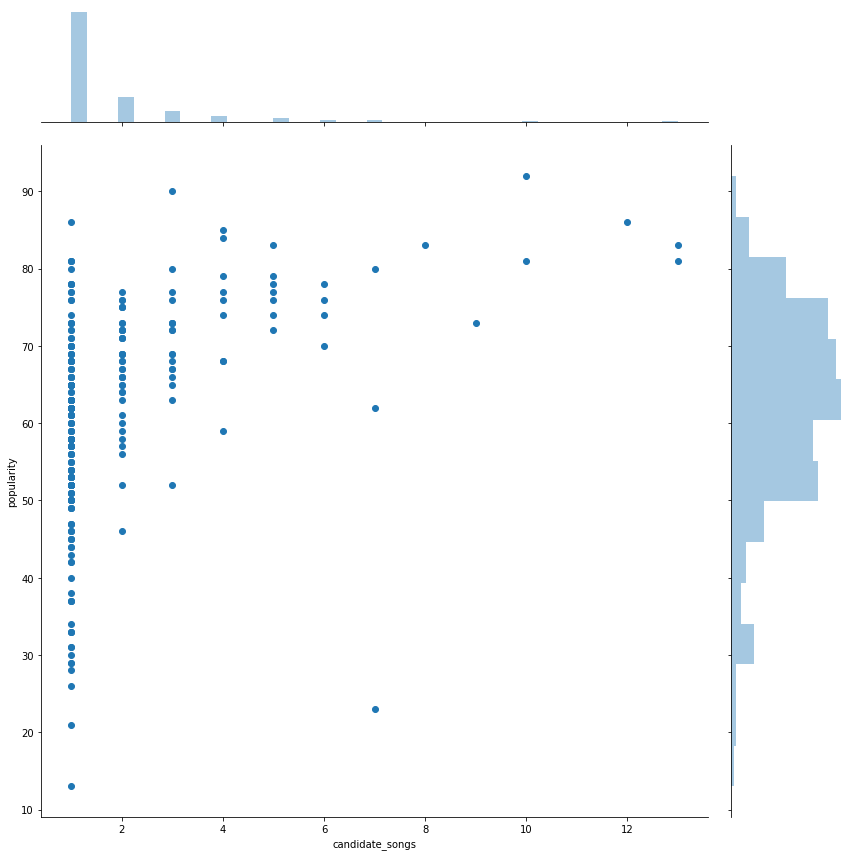

In [490]:
sns.jointplot(x="candidate_songs", y="popularity", data=artists_df, height=12)

There is one distinct outlier, which entered over 6 songs while having popularity of under 30. Let's find out who that might be.

In [460]:
display(artists_df.loc[artists_df['popularity'] < 30].loc[artists_df['candidate_songs'] > 6])

,name,candidate_songs,first_letter,song_ratio,popularity,avg_song_pop,max_song_pop,min_song_pop,genres,sum_views,avg_views,avg_old_chart,count_old_chart,avg_new_chart,count_new_chart,song_pop_difference
7,Pink Floyd,7,P,0.012072,23,59.714286,74,18,"{'Progressive rock': 6, 'Art rock': 1, 'Experi...",640384,91483.428571,19.0,1,37.0,2,56


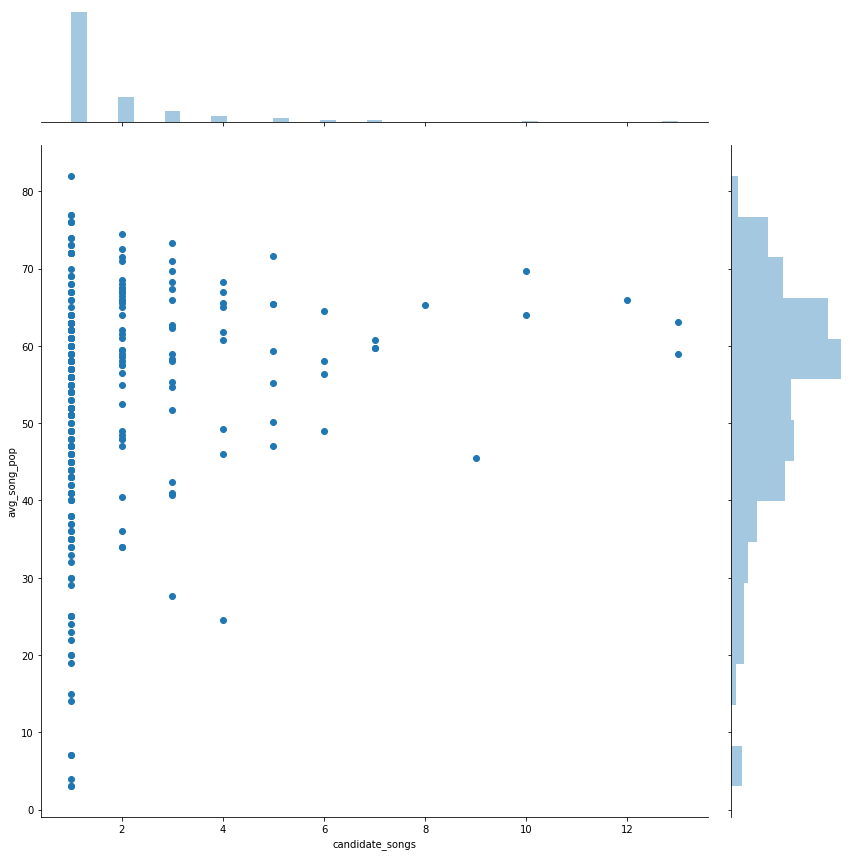

In [201]:
sns.jointplot(x="candidate_songs", y="avg_song_pop", data=artists_df, height=12)

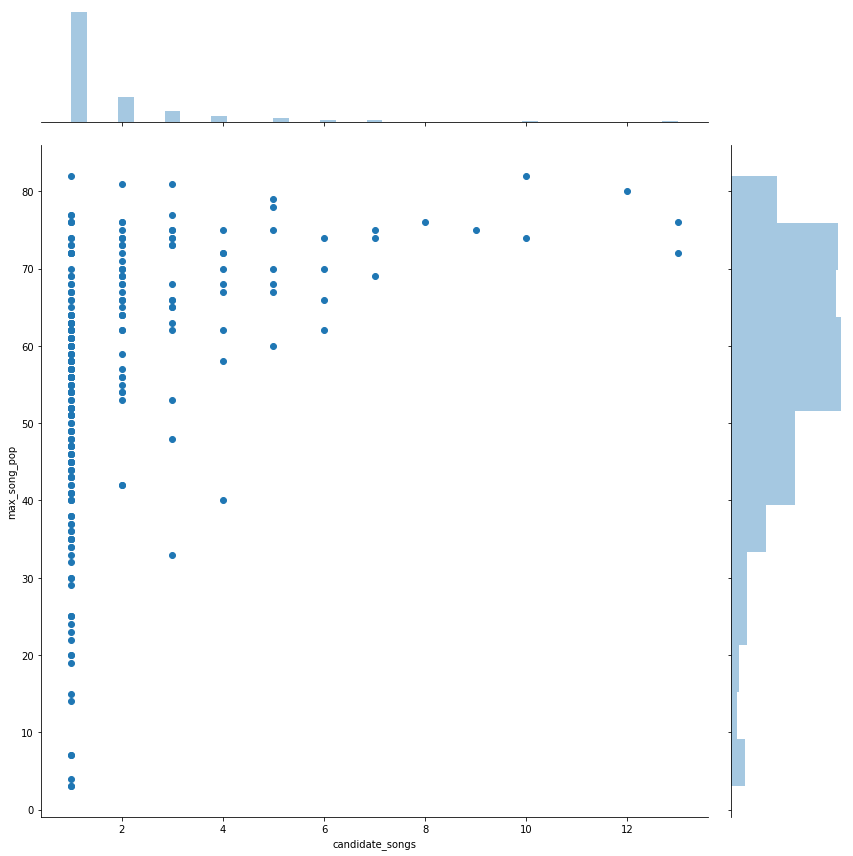

In [202]:
sns.jointplot(x="candidate_songs", y="max_song_pop", data=artists_df, height=12)

So far I didn't find any interesting connections. Just out of curiousity, let's find out which artist has the biggest difference between two songs nomineed. Is it one of those who entered more than 10 songs?

In [491]:
artists_df['song_pop_difference'] = artists_df['max_song_pop'].sub(artists_df['min_song_pop']).to_frame('col')
display(artists_df.loc[artists_df['song_pop_difference'].idxmax()])

name                                                         John Lennon
candidate_songs                                                        9
first_letter                                                           J
popularity                                                            73
avg_song_pop                                                     45.5556
max_song_pop                                                          75
min_song_pop                                                           4
genres                 {'Rhythm and blues': 1, 'Soul music': 1, 'Soft...
sum_views                                                         625622
avg_views                                                        69513.6
avg_old_chart                                                          4
count_old_chart                                                        1
avg_new_chart                                                       43.5
count_new_chart                                    

It turns out that it is John Lennon! He might not be one of the artists who inserted more than ten songs to the nomination list, but he has no less than 9 nominee songs! The least popular of which has a popularity rate of only 4(!). I wonder of the least popular songs who entered the list are ones of artists who inserted many songs.

1    17
3     3
2     3
9     1
7     1
6     1
4     1
Name: candidate_songs, dtype: int64


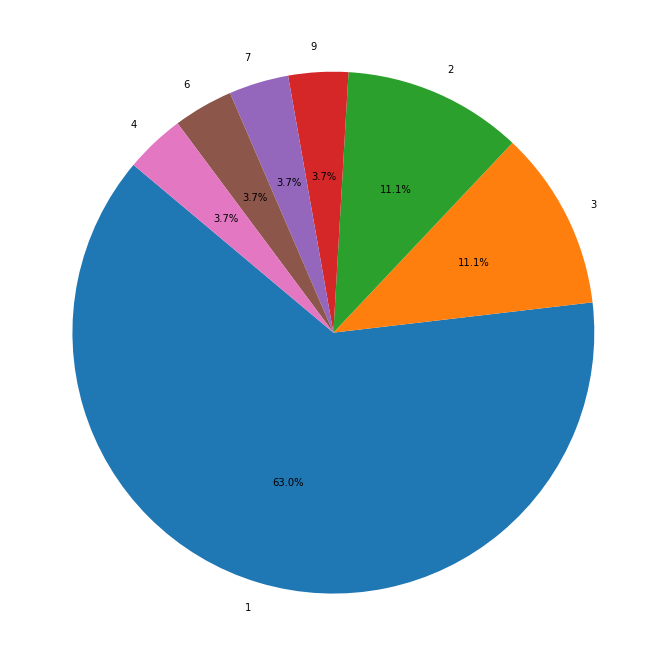

In [492]:
not_popular_songs = artists_df.loc[artists_df['min_song_pop'] < 30]
nps_value_counts = not_popular_songs.candidate_songs.value_counts()
print(nps_value_counts)
plt.figure(figsize=(12,12))
plt.pie(nps_value_counts, labels=nps_value_counts.index,
autopct='%1.1f%%', startangle=140)
plt.show()

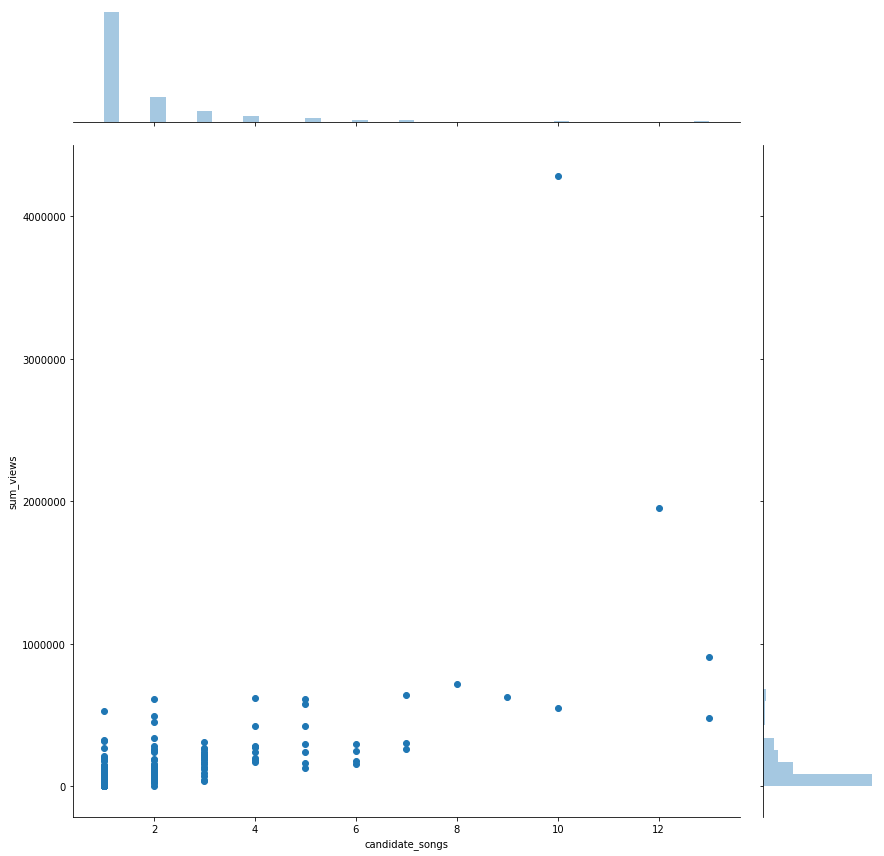

In [264]:
sns.jointplot(x="candidate_songs", y="sum_views", data=artists_df, height=12)

Looking at the least popular songs and the amount of nominee songs, at looked quite similar to the general population - therefore I concluded that there is no distinct connection to be seen. I moved on to find a connection between the sum of views of song's wikipedia pages, and the number of nominee songs. I found two outliers with over 1000000 Wikipedia views in 2019. Let's find out who they are.

In [493]:
display(artists_df.loc[artists_df['sum_views'] > 1000000])

,name,candidate_songs,first_letter,popularity,avg_song_pop,max_song_pop,min_song_pop,genres,sum_views,avg_views,avg_old_chart,count_old_chart,avg_new_chart,count_new_chart,song_pop_difference
2,Elton John,12,E,86,65.916667,80,44,"{'Pop music': 2, 'Soft rock': 4, 'Rock music':...",1952223,162685.25,12.4,5,60.000000,6,36
3,Queen,10,Q,92,69.700000,82,46,"{'Art pop': 1, 'Glam rock': 2, 'Power pop': 2,...",4282865,428286.50,13.5,2,18.428571,7,36


The results are not surprising. Those artists have one of the highest amount of nominee songs. Moreover, both of these artists have a successfull Hollywood movies based upon, which boosted their Wikipedia popularity.

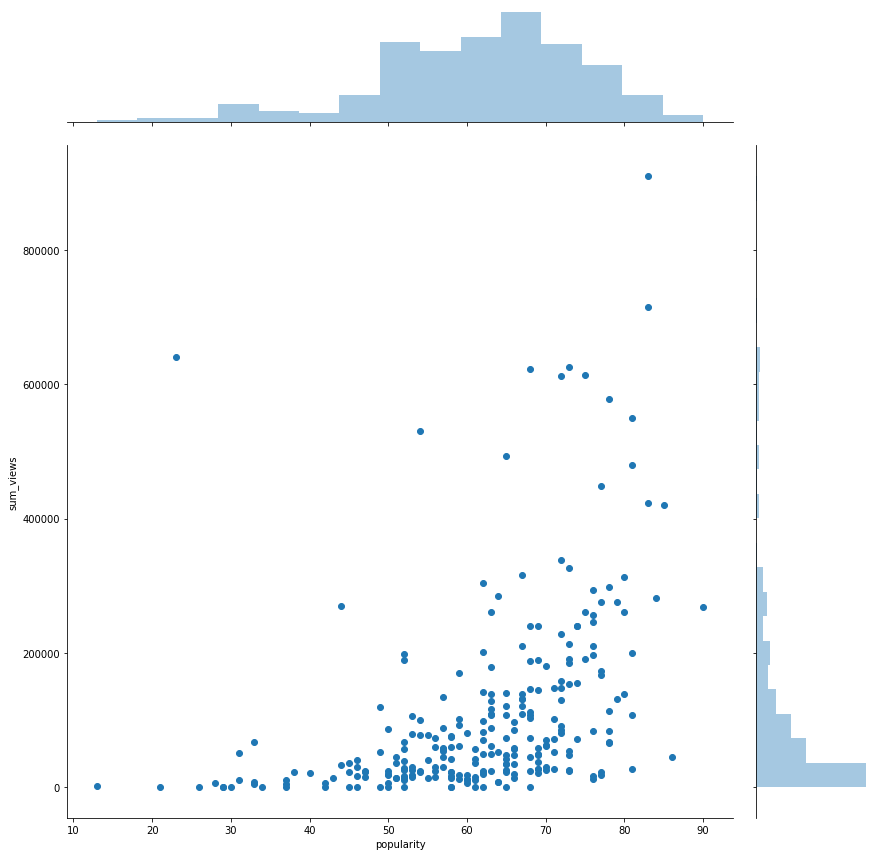

In [268]:
sns.jointplot(x="popularity", y="sum_views", data=artists_df.loc[artists_df['sum_views'] < 1000000], height=12)

In [272]:
display(artists_df.loc[artists_df['sum_views'] < 200000].loc[artists_df['popularity'] > 80])

,name,candidate_songs,first_letter,song_ratio,popularity,avg_song_pop,max_song_pop,min_song_pop,genres,sum_views,avg_views,avg_old_chart,count_old_chart,avg_new_chart,count_new_chart,song_pop_difference
101,Elvis Presley,1,E,0.002012,81,55.0,55,55,{},199771,199771.0,NaN,0,72.0,1,0
161,Bruce Springsteen,1,B,0.002012,81,72.0,72,72,"{'Rock music': 1, 'Power pop': 1}",27100,27100.0,NaN,0,NaN,0,0
232,AC/DC,1,A,0.002012,86,82.0,82,82,{'Hard rock': 1},45645,45645.0,NaN,0,21.0,1,0
246,Creedence Clearwater Revival,1,C,0.002012,81,76.0,76,76,"{'Roots rock': 1, 'Country rock': 1}",107193,107193.0,NaN,0,NaN,0,0


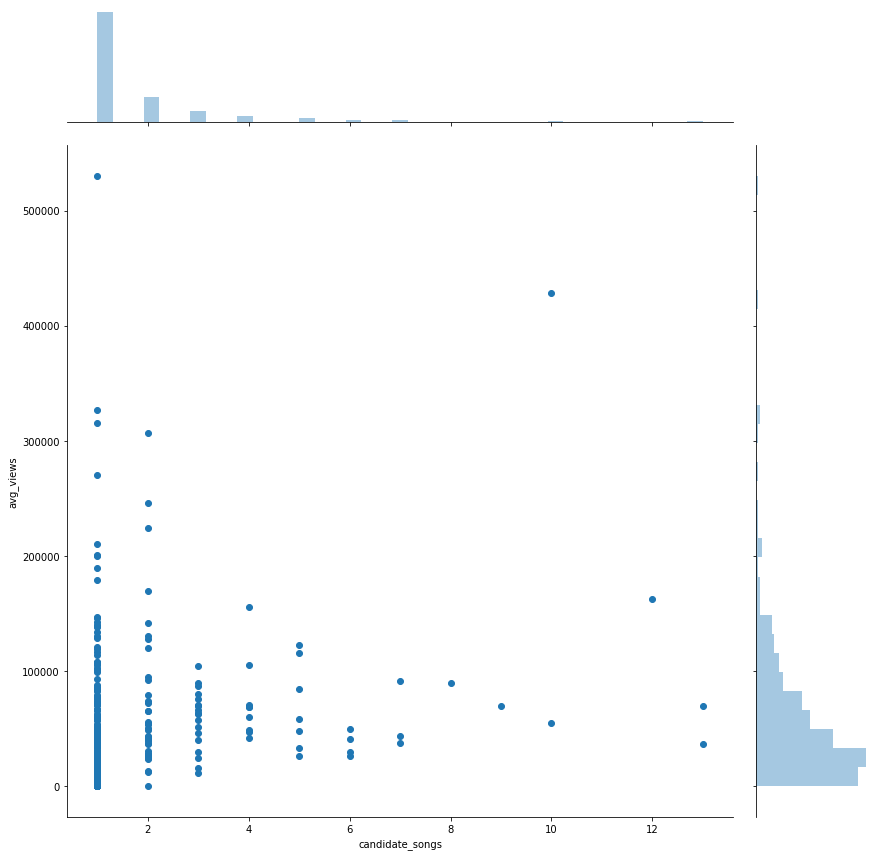

In [274]:
sns.jointplot(x="candidate_songs", y="avg_views", data=artists_df, height=12)

Looking at the amount of candidate songs in relation to Wikipedia views, I can see an artist who inserted only one song to the nomination list, and yet it enjoys more than 400000 Wikipedia entries. Finding out who that might be revealed the following outcome:

In [275]:
display(artists_df.loc[artists_df['avg_views'] > 400000])

,name,candidate_songs,first_letter,song_ratio,popularity,avg_song_pop,max_song_pop,min_song_pop,genres,sum_views,avg_views,avg_old_chart,count_old_chart,avg_new_chart,count_new_chart,song_pop_difference
3,Queen,10,Q,0.020121,92,69.7,82,46,"{'Art pop': 1, 'Glam rock': 2, 'Power pop': 2,...",4282865,428286.5,13.5,2,18.428571,7,36
129,CAN,1,C,0.002012,54,50.0,50,50,{},530093,530093.0,NaN,0,NaN,0,0


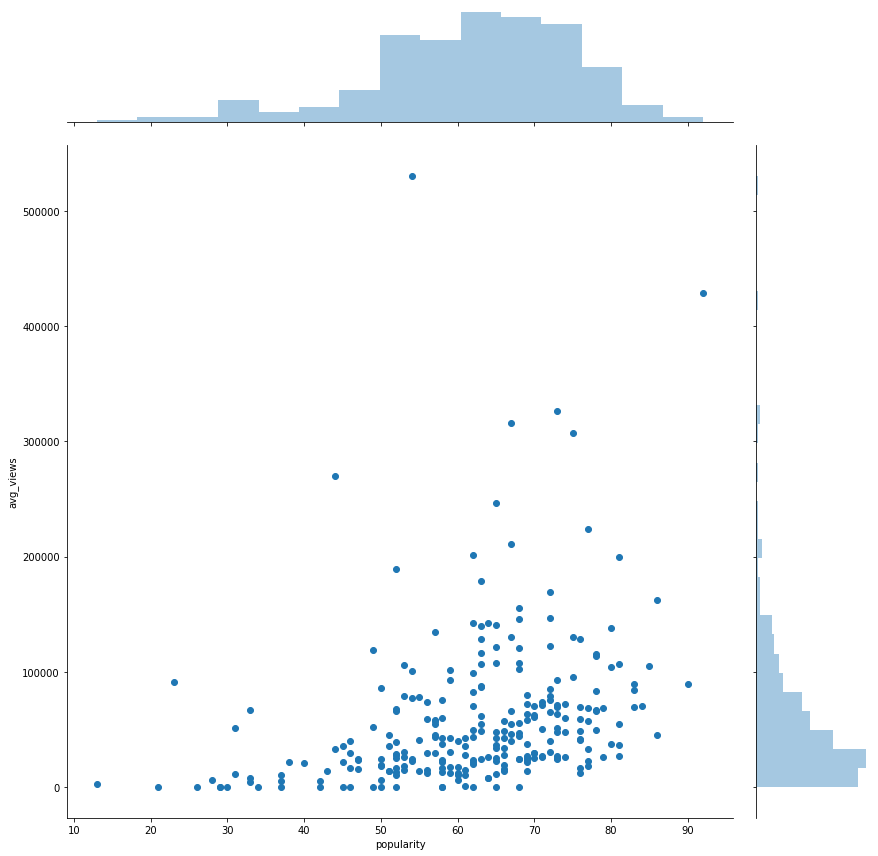

In [277]:
sns.jointplot(x="popularity", y="avg_views", data=artists_df, height=12)

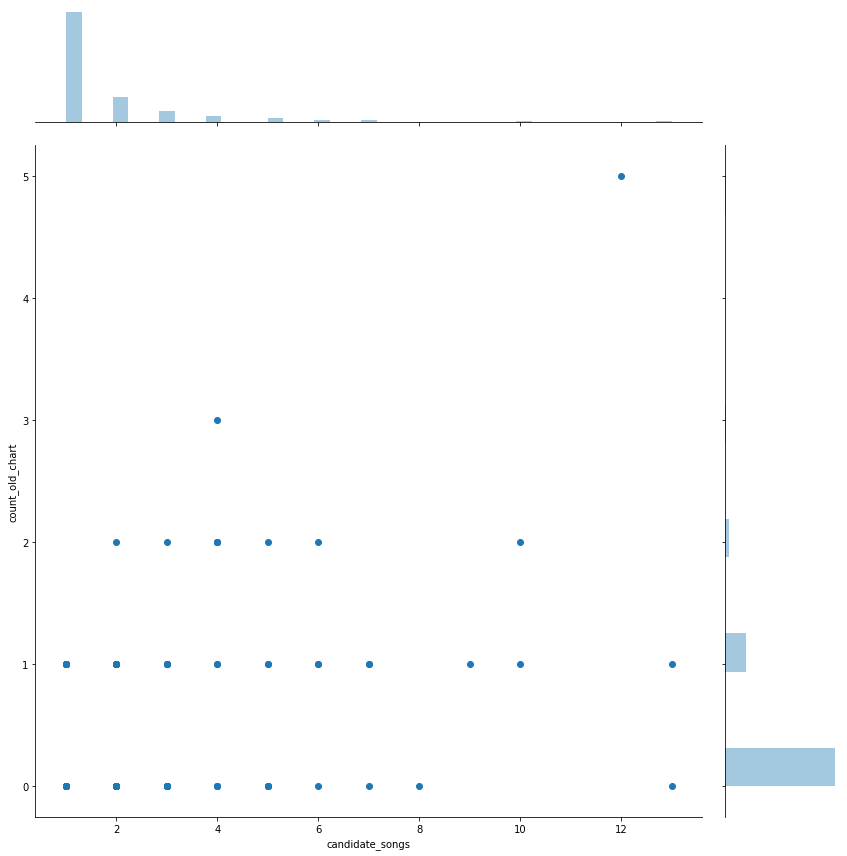

In [281]:
sns.jointplot(x="candidate_songs", y="count_old_chart", data=artists_df, height=12)

Only one artist have entered more than 4 nominee songs:

In [282]:
display(artists_df.loc[artists_df['count_old_chart'] > 4])

,name,candidate_songs,first_letter,song_ratio,popularity,avg_song_pop,max_song_pop,min_song_pop,genres,sum_views,avg_views,avg_old_chart,count_old_chart,avg_new_chart,count_new_chart,song_pop_difference
2,Elton John,12,E,0.024145,86,65.916667,80,44,"{'Pop music': 2, 'Soft rock': 4, 'Rock music':...",1952223,162685.25,12.4,5,60.0,6,36


## Making a table of artists grouped by their first letter

In [494]:
first_letters = artists_df.groupby('first_letter')
fl_df = []
for group in first_letters:
    first_letter = {}
    first_letter['name'] = group[0]
    first_letter['count_artists'] = group[1]['name'].count()
    first_letter['sum_candidate_songs'] = group[1]['candidate_songs'].sum()
    first_letter['sum_popularity'] = group[1]['popularity'].sum()
    first_letter['sum_views'] = group[1]['sum_views'].sum()
    first_letter['count_old_chart'] = group[1]['count_old_chart'].sum()
    first_letter['avg_new_chart'] = group[1]['avg_new_chart'].mean()
    first_letter['count_new_chart'] = group[1]['count_new_chart'].sum()
    fl_df.append(first_letter)
fl_df = pd.DataFrame(fl_df)
print(fl_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
name                   25 non-null object
count_artists          25 non-null int64
sum_candidate_songs    25 non-null int64
sum_popularity         25 non-null int64
sum_views              25 non-null int64
count_old_chart        25 non-null int64
avg_new_chart          18 non-null float64
count_new_chart        25 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ KB
None


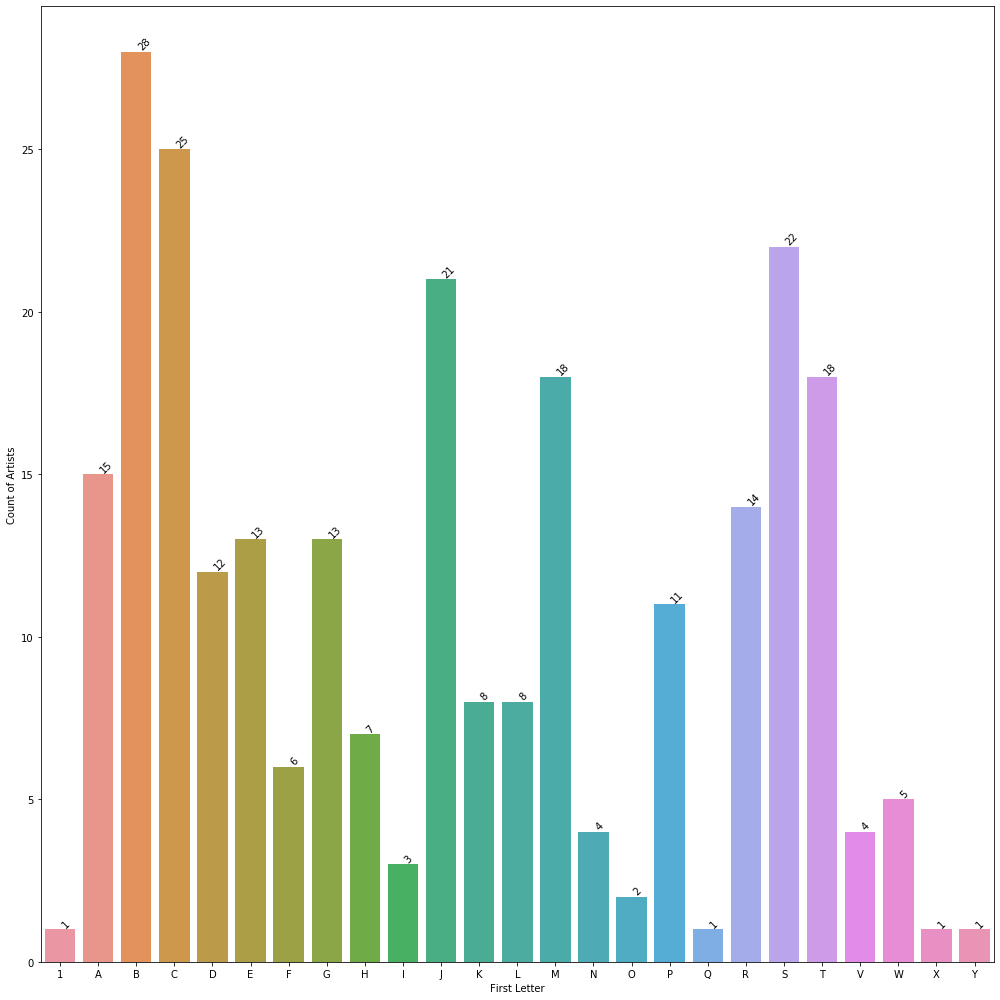

In [495]:
plt.figure(figsize=(14,14))
ax = sns.barplot(x=fl_df.name, y=fl_df.count_artists)
ax.set(xlabel="First Letter", ylabel='Count of Artists')
for i, v in enumerate(fl_df.count_artists):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

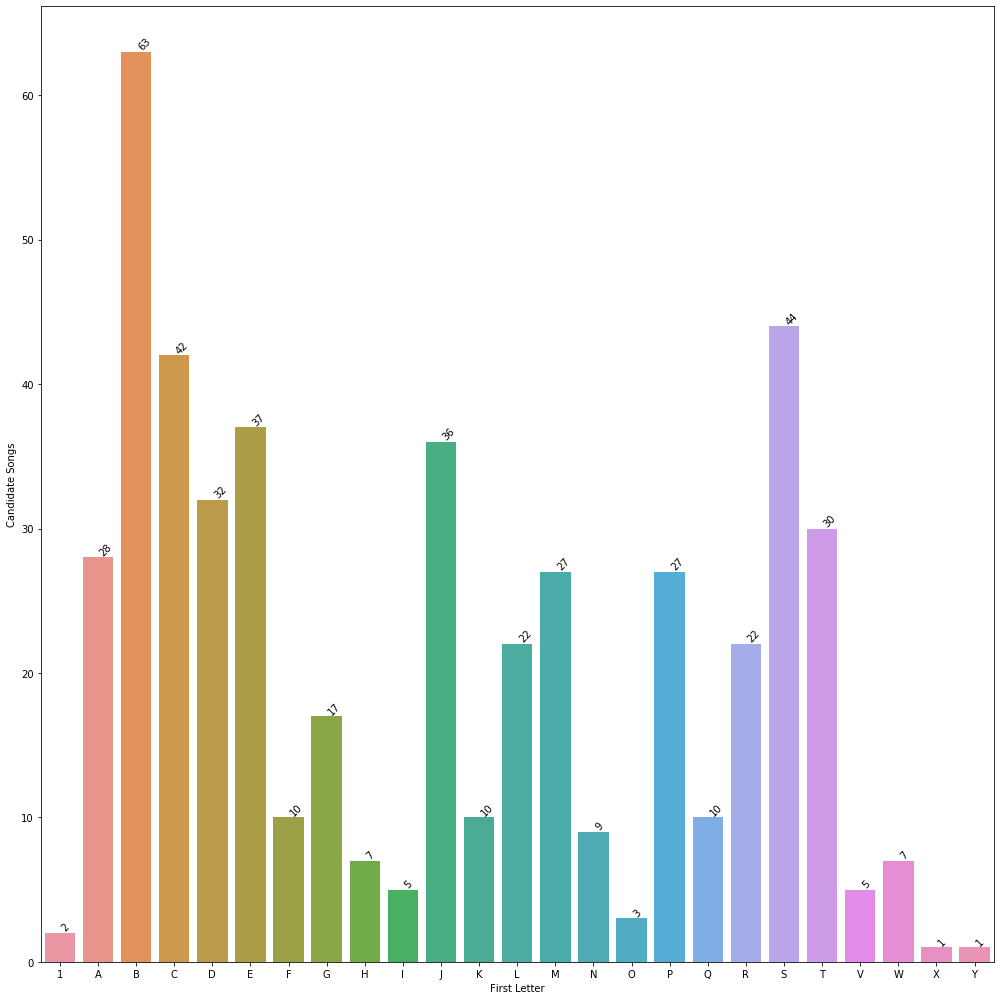

In [496]:
plt.figure(figsize=(14,14))
ax = sns.barplot(x=fl_df.name, y=fl_df.sum_candidate_songs)
ax.set(xlabel="First Letter", ylabel='Candidate Songs')
for i, v in enumerate(fl_df.sum_candidate_songs):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

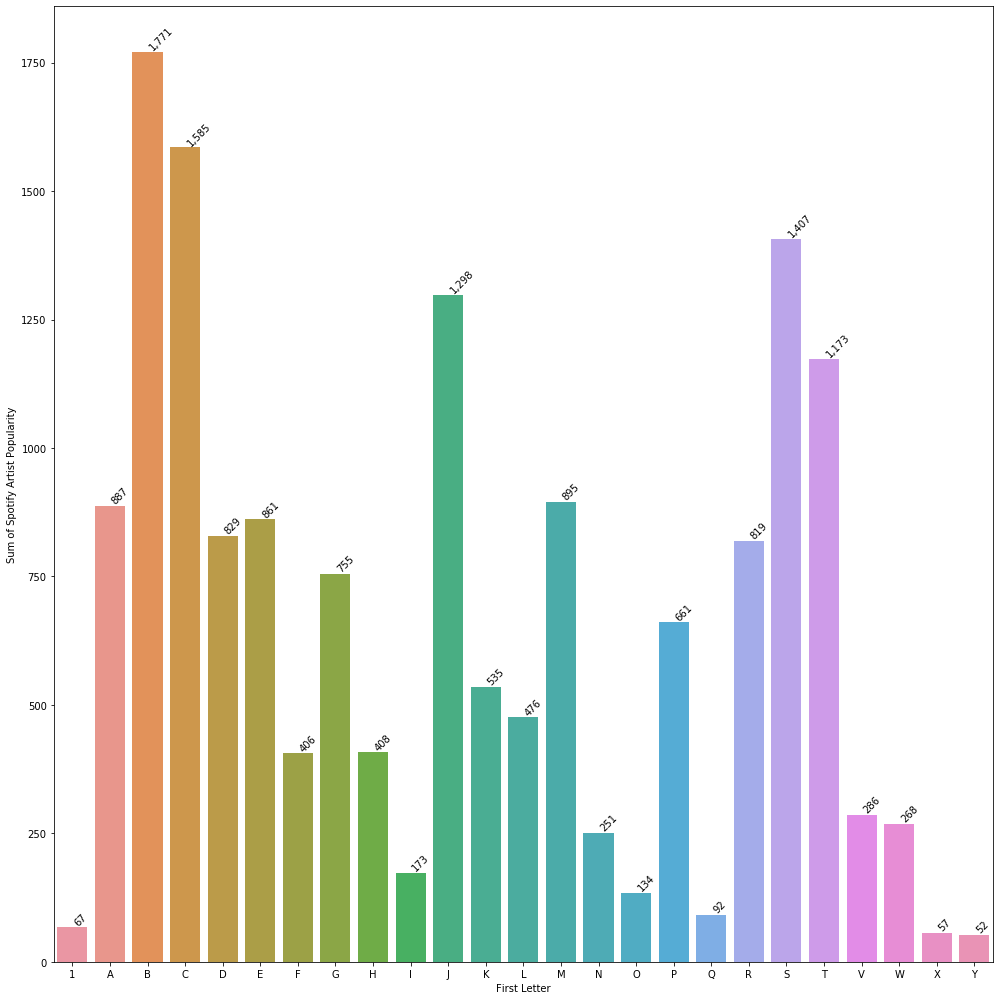

In [340]:
plt.figure(figsize=(14,14))
ax = sns.barplot(x=fl_df.name, y=fl_df.sum_popularity)
ax.set(xlabel="First Letter", ylabel='Sum of Spotify Artist Popularity')
for i, v in enumerate(fl_df.sum_popularity):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

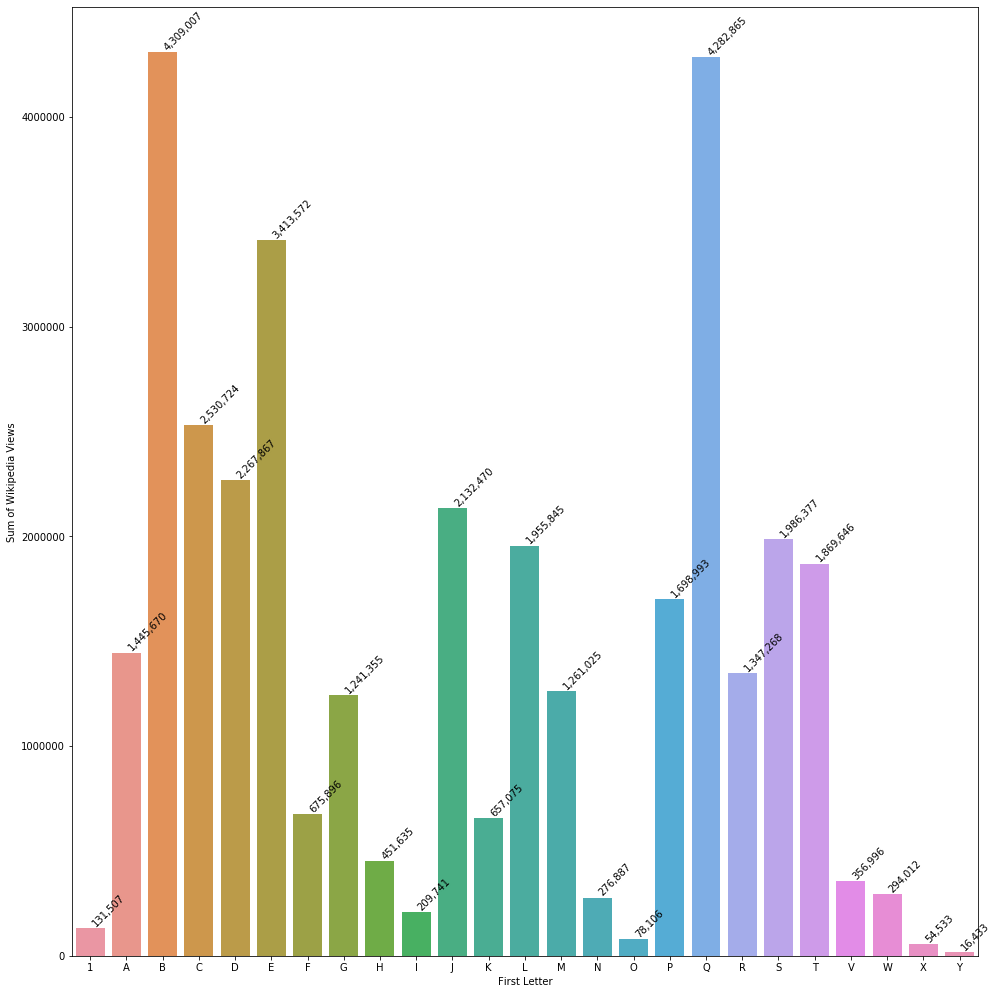

In [341]:
plt.figure(figsize=(14,14))
ax = sns.barplot(x=fl_df.name, y=fl_df.sum_views)
ax.set(xlabel="First Letter", ylabel='Sum of Wikipedia Views')
#for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(fl_df.sum_views):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

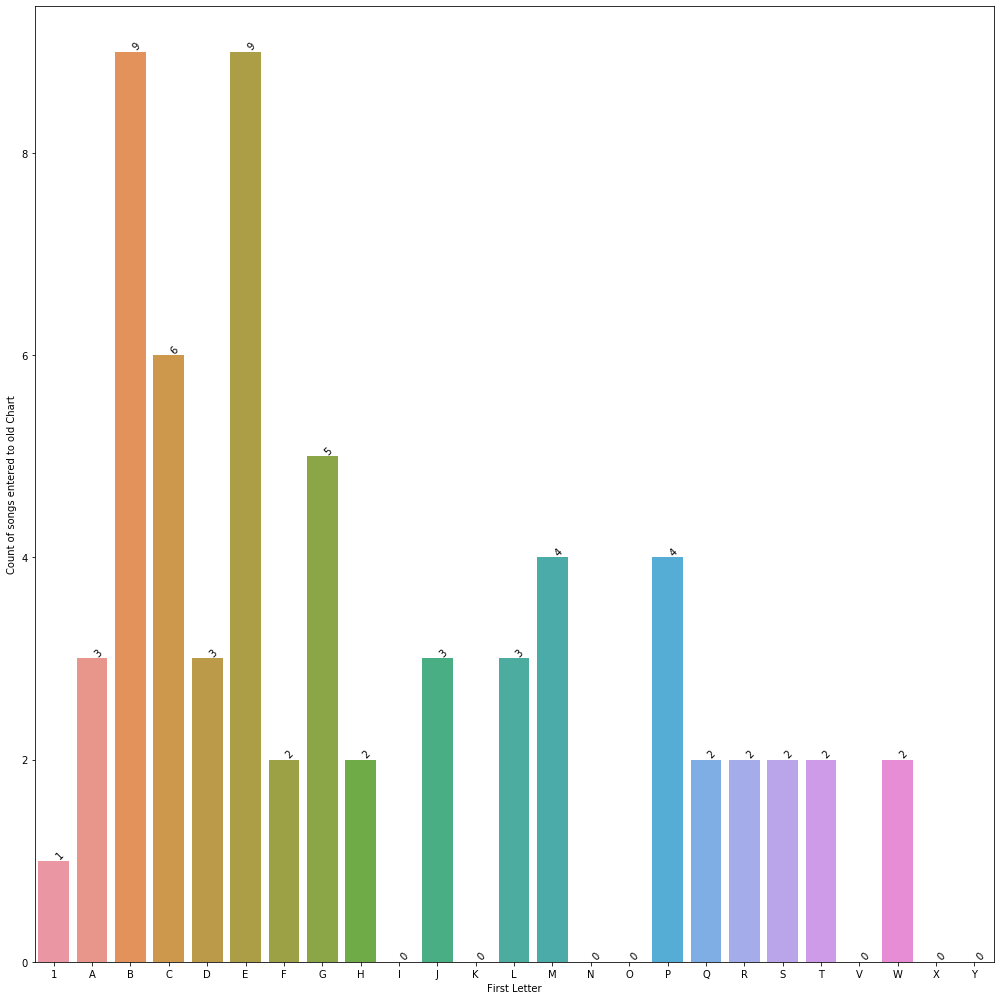

In [467]:
plt.figure(figsize=(14,14))
ax = sns.barplot(x=fl_df.name, y=fl_df.count_old_chart)
ax.set(xlabel="First Letter", ylabel='Count of songs entered to old Chart')
#for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(fl_df.count_old_chart):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

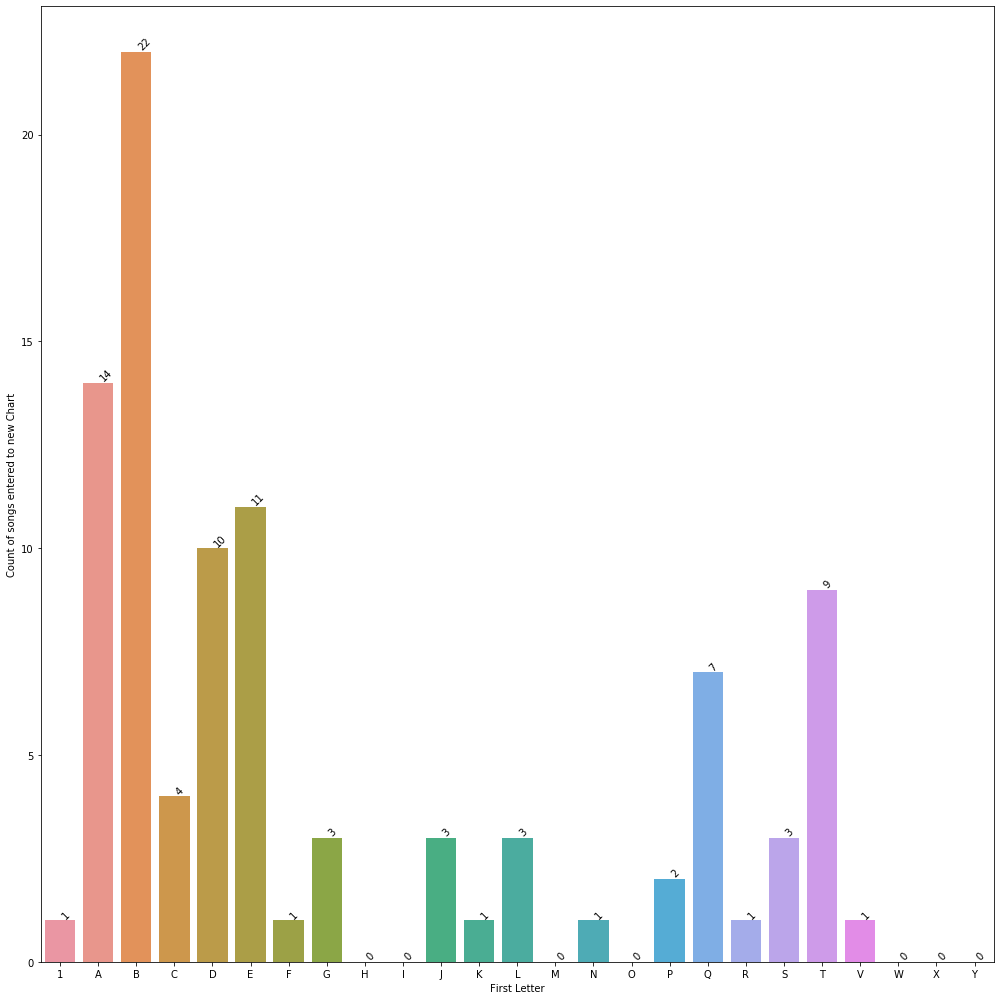

In [468]:
plt.figure(figsize=(14,14))
ax = sns.barplot(x=fl_df.name, y=fl_df.count_new_chart)
ax.set(xlabel="First Letter", ylabel='Count of songs entered to new Chart')
#for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(fl_df.count_new_chart):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

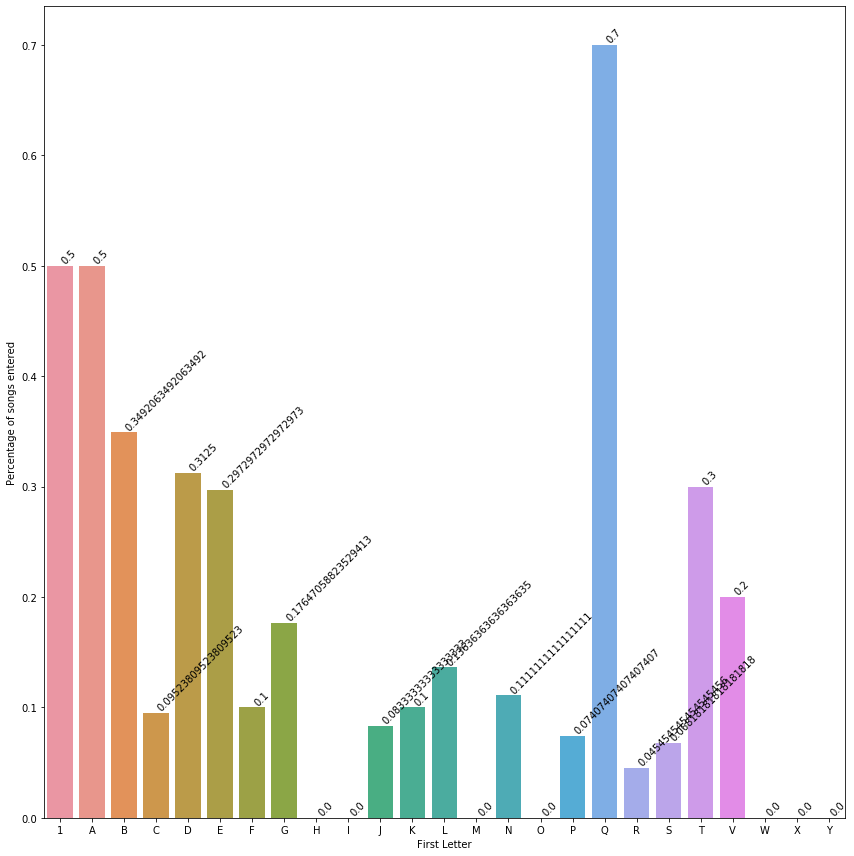

In [469]:
fl_df['entrance_percentage'] = fl_df['count_new_chart'].div(fl_df['sum_candidate_songs']).to_frame('col')
plt.figure(figsize=(12,12))
ax = sns.barplot(x=fl_df.name, y=fl_df.entrance_percentage)
ax.set(xlabel="First Letter", ylabel='Percentage of songs entered')
#for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(fl_df.entrance_percentage):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

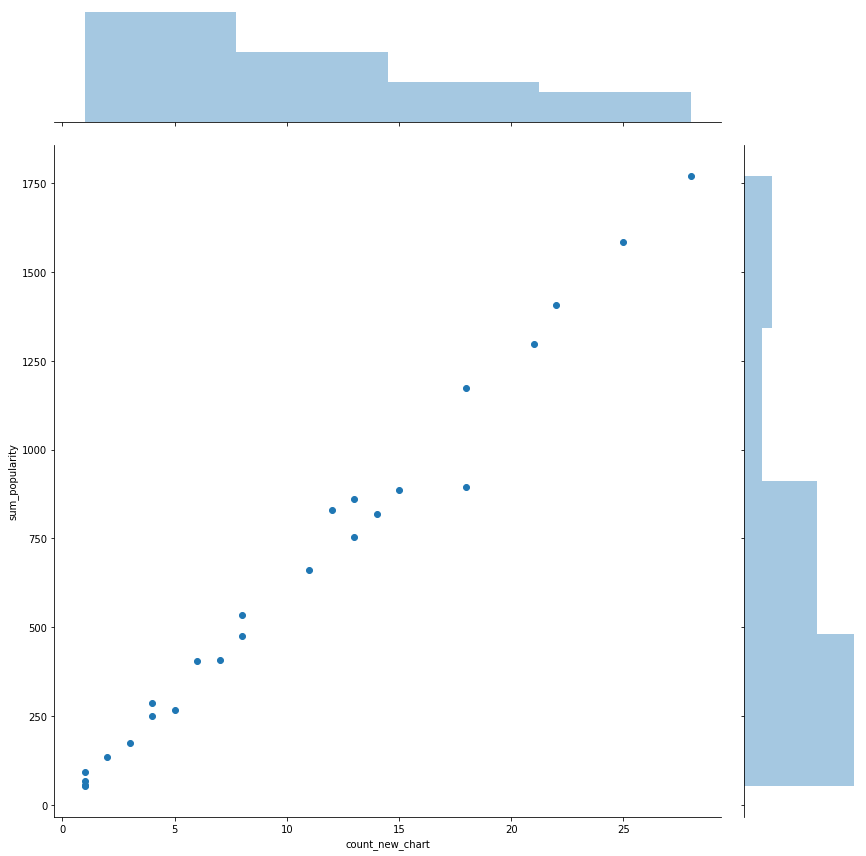

In [350]:
sns.jointplot(x="count_new_chart", y="sum_popularity", data=fl_df, height=12)

## Looking for year distribution

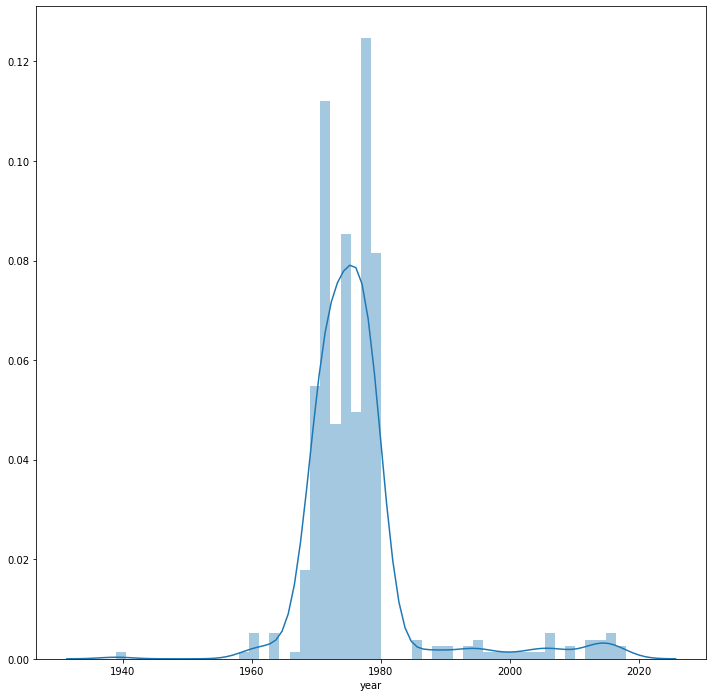

In [355]:
plt.figure(figsize=(12,12))
sns.distplot(seventies_df.year)

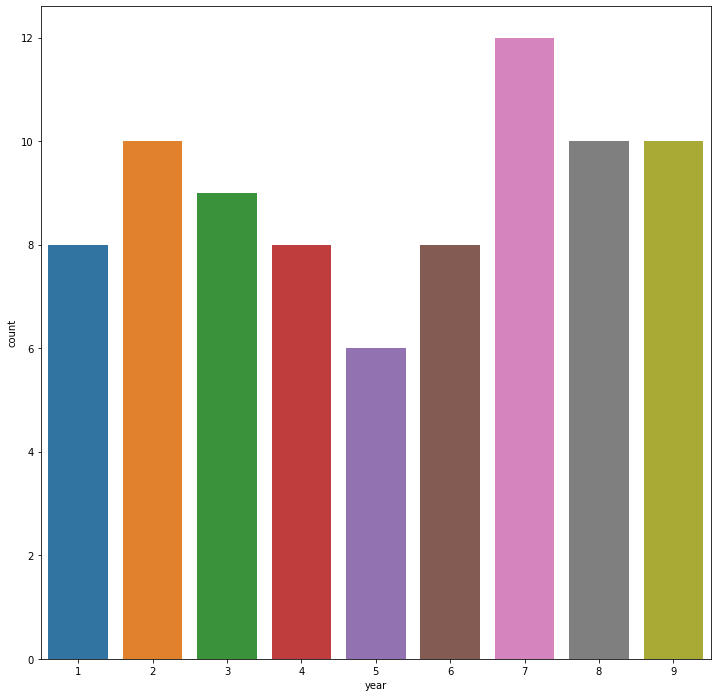

In [366]:
correct_year = seventies_df.loc[seventies_df['year'] < 1980].loc[seventies_df['year'] > 1970]
correct_year['year'] = correct_year['year'] - 1970
plt.figure(figsize=(12,12))
sns.countplot(x="year", data=correct_year.loc[correct_year['new_chart_location'] > 0])

## Looking for connection between chart location and popularity values from Spotify

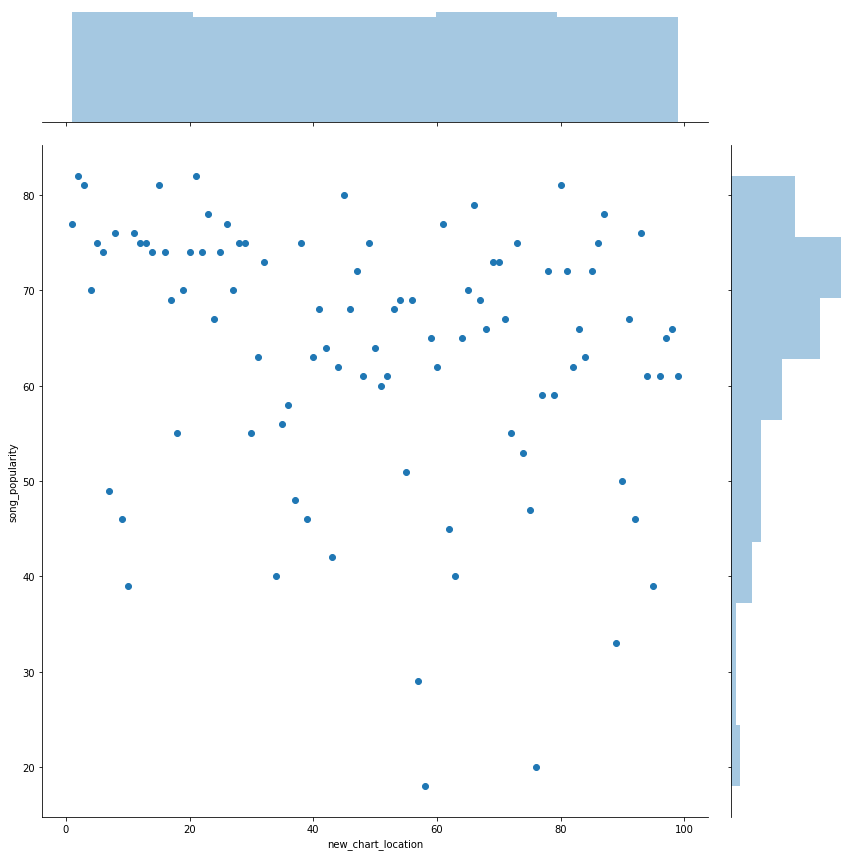

In [372]:
sns.jointplot(x="new_chart_location", y="song_popularity", data=seventies_df.loc[seventies_df['new_chart_location'] > 0], height=12)

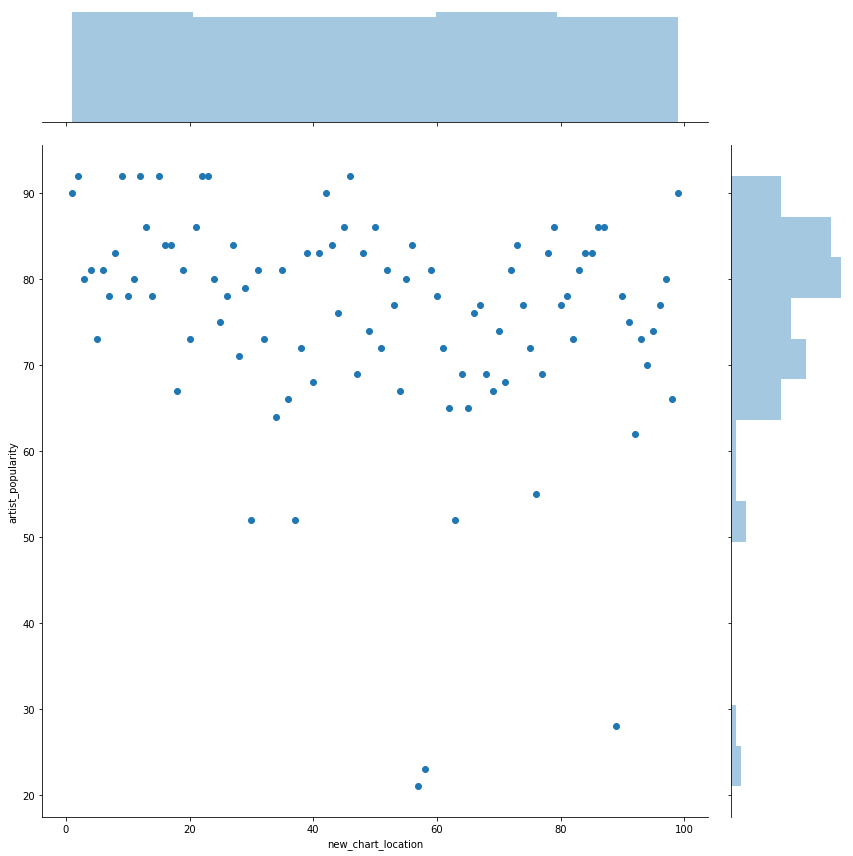

In [373]:
sns.jointplot(x="new_chart_location", y="artist_popularity", data=seventies_df.loc[seventies_df['new_chart_location'] > 0], height=12)

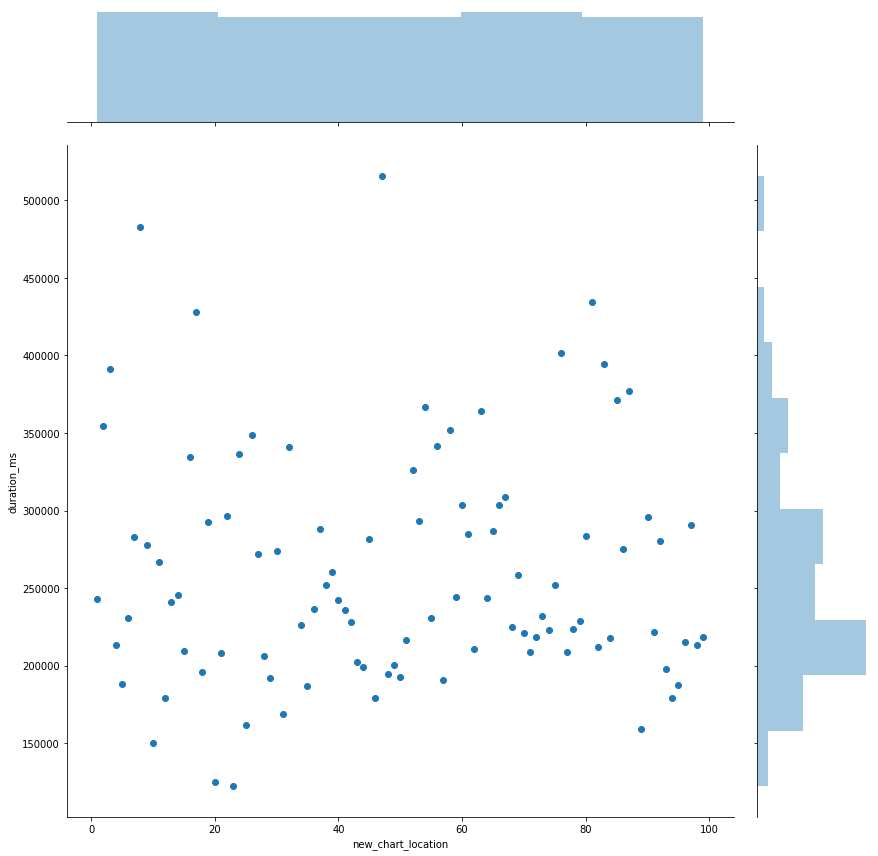

In [374]:
sns.jointplot(x="new_chart_location", y="duration_ms", data=seventies_df.loc[seventies_df['new_chart_location'] > 0], height=12)

After I found no visible connection, I have decided to compare the songs that entered to the chart to the ones who didn't.

In [462]:
seventies_df["entered_chart"] = seventies_df["new_chart_location"] > 0
entered_chart = seventies_df.groupby('entered_chart')
entered_df = []
for group in entered_chart:
    bol = {}
    bol['name'] = group[0]
    bol['avg_song_popularity'] = group[1]['song_popularity'].mean()
    bol['avg_artist_popularity'] = group[1]['artist_popularity'].mean()
    bol['avg_duration'] = group[1]['duration_ms'].mean()
    bol['avg_key'] = group[1]['key'].mean()
    bol['avg_time_signature'] = group[1]['time_signature'].mean()
    bol['avg_acousticness'] = group[1]['acousticness'].mean()
    bol['avg_danceability'] = group[1]['danceability'].mean()
    bol['avg_energy'] = group[1]['energy'].mean()
    bol['avg_instrumentalness'] = group[1]['instrumentalness'].mean()
    bol['avg_loudness'] = group[1]['loudness'].mean()
    bol['avg_speechiness'] = group[1]['speechiness'].mean()
    bol['avg_valence'] = group[1]['valence'].mean()
    bol['avg_tempo'] = group[1]['tempo'].mean()
    bol['avg_views'] = group[1]['views'].mean()
    bol['avg_year'] = group[1]['year'].mean()
    bol['count_old_position'] = group[1]['old_chart_position'].loc[group[1]['old_chart_position'] > 0].count()
    entered_df.append(bol)
entered_df = pd.DataFrame(entered_df)
display(entered_df)

,name,avg_song_popularity,avg_artist_popularity,avg_duration,avg_key,avg_time_signature,avg_acousticness,avg_danceability,avg_energy,avg_instrumentalness,avg_loudness,avg_speechiness,avg_valence,avg_tempo,avg_views,avg_year,count_old_position
0,False,54.175000,66.822500,248302.187500,5.135000,3.930000,0.311794,0.566908,0.584701,0.055456,-10.332968,0.052118,0.625416,120.267415,53705.775000,1976.515000,45
1,True,63.989691,75.690722,259529.793814,5.453608,3.927835,0.367487,0.530299,0.558268,0.025068,-9.713763,0.053288,0.543847,121.693505,138795.824742,1975.525773,19


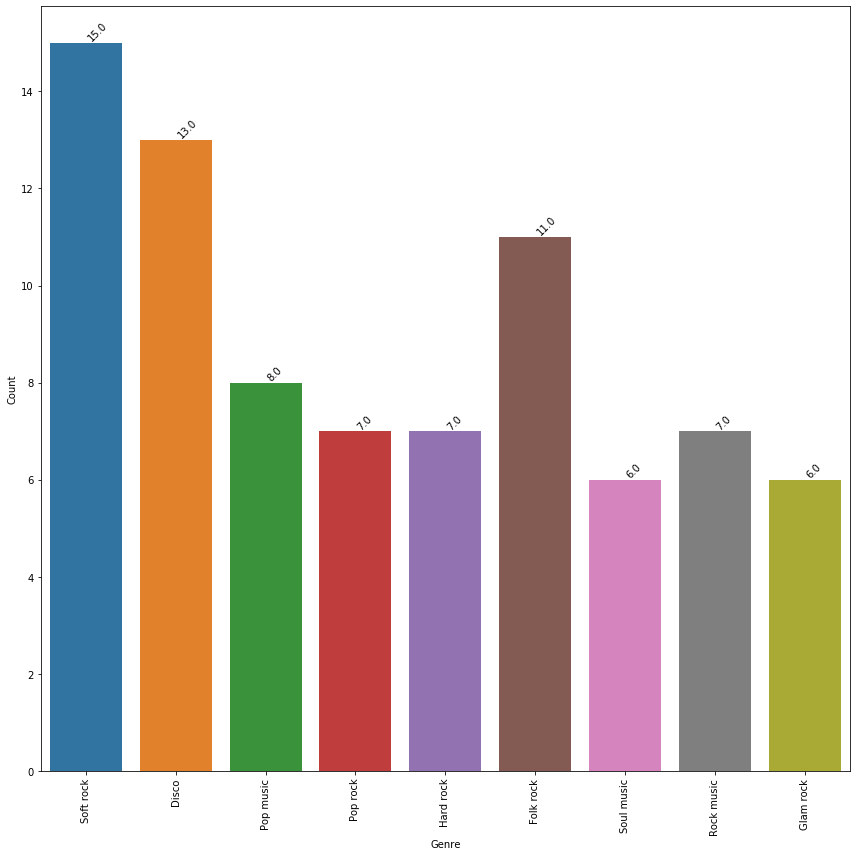

In [499]:
entered_songs = seventies_df.loc[seventies_df['entered_chart'] == True]
genres_dict = {}
for song_genre in entered_songs['genres']:
    for genre in song_genre.split(","):
        if len(re.findall(r"'([^']*)'", genre))>0:
            if re.findall(r"'([^']*)'", genre)[0] in genres_dict.keys():
                genres_dict[re.findall(r"'([^']*)'", genre)[0]] = genres_dict[re.findall(r"'([^']*)'", genre)[0]] + 1
            else:
                genres_dict[re.findall(r"'([^']*)'", genre)[0]] = 1
            #print(genres_dict)
newDict = dict(filter(lambda elem: elem[1] > 5,genres_dict.items()))
plt.figure(figsize=(12,12))
ax = sns.barplot(x=list(newDict.keys()), y=np.array(list(newDict.values())).astype(float))
ax.set(xlabel="Genre", ylabel='Count')
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(np.array(list(newDict.values())).astype(float)):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

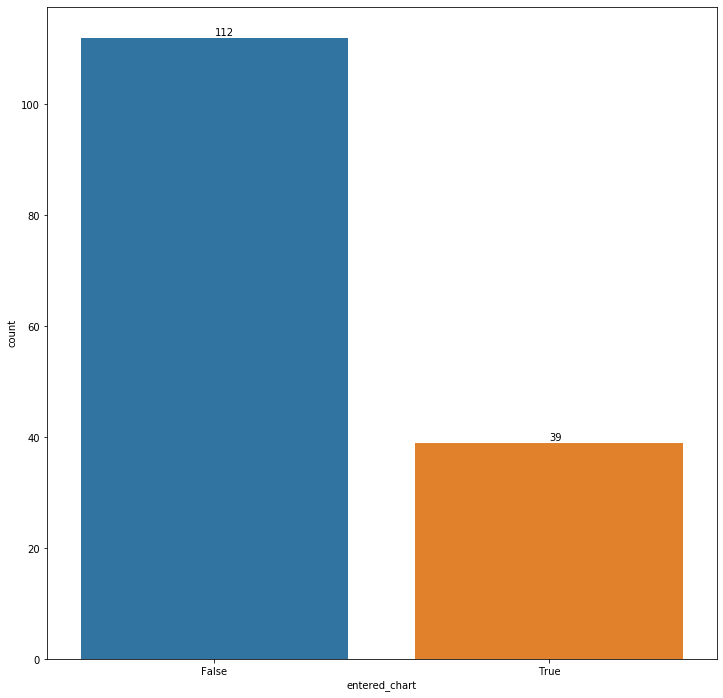

In [449]:
top_genres = pd.DataFrame(columns = seventies_df.columns)
i = 0
for index, row in seventies_df.iterrows():
    for genre in row.genres.split(","):
        if len(re.findall(r"'([^']*)'", genre))>0:
            if re.findall(r"'([^']*)'", genre)[0] in ['Soft rock', 'Disco', 'Folk rock']:
                top_genres.loc[i] = row
                i = i + 1
plt.figure(figsize=(12,12))                
ax = sns.countplot(x=top_genres.entered_chart)
for i, v in enumerate(top_genres.entered_chart.value_counts()):
    ax.text(i ,v, "{:,}".format(v), va ='bottom')    

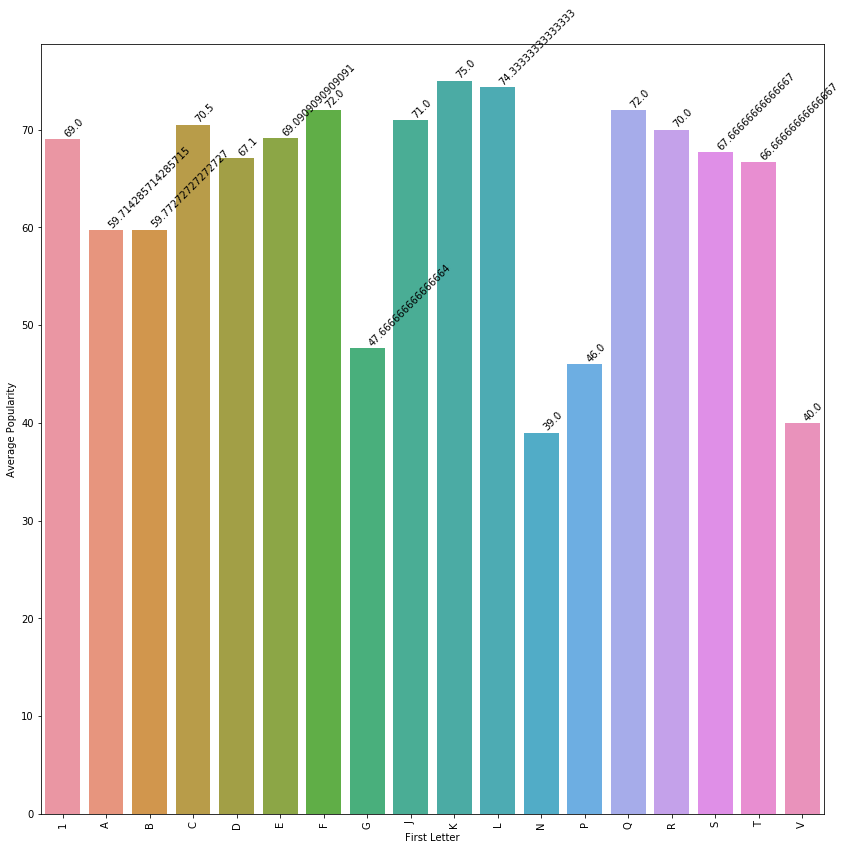

In [501]:
entered_first_letter = entered_songs.groupby('artist_first_letter')
entered_fl_df = []
for group in entered_first_letter:
    entered_fl = {}
    entered_fl['name'] = group[0]
    entered_fl['avg_song_popularity'] = group[1]['song_popularity'].mean()
    entered_fl_df.append(entered_fl)
entered_fl_df = pd.DataFrame(entered_fl_df)
plt.figure(figsize=(12,12))
ax = sns.barplot(x=entered_fl_df.name, y=entered_fl_df.avg_song_popularity)
ax.set(xlabel="First Letter", ylabel='Average Popularity')
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(entered_fl_df.avg_song_popularity):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

I want to have a clear sense of whether it's easier for a song in the first letters to get into the chart than the rest of the songs, therefore I am performing the following aggregation:

,Name,Count,Popularity,Avg_Popularity
0,First Letters,41,2502,61.024390
1,Rest of the Letters,56,3705,66.160714


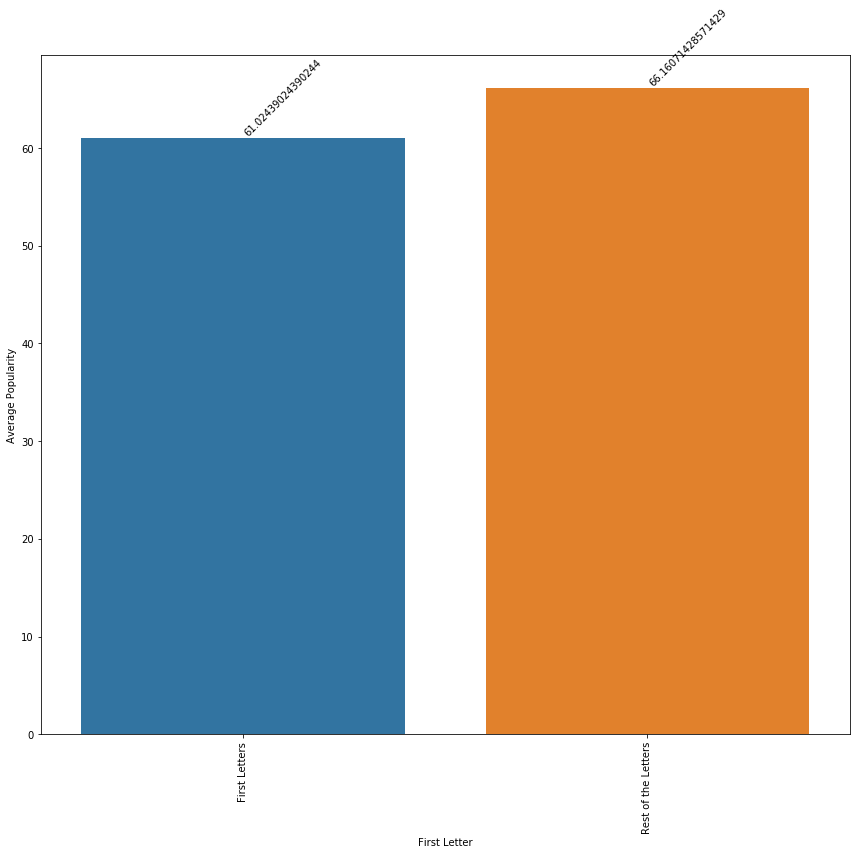

In [502]:
count_first_songs = 0
popularity_first_rate = 0
count_last_songs = 0
popularity_last_rate = 0
for fl in entered_first_letter:
    if fl[0] in ['1', 'A', 'B', 'C']:
        count_first_songs = count_first_songs + fl[1]['name'].count()
        popularity_first_rate = popularity_first_rate + fl[1]['song_popularity'].sum()
    else:
        count_last_songs = count_last_songs + fl[1]['name'].count()
        popularity_last_rate = popularity_last_rate + fl[1]['song_popularity'].sum()
comparing_letters = pd.DataFrame({'Name': ['First Letters', 'Rest of the Letters'], 'Count': [count_first_songs, count_last_songs], 'Popularity': [popularity_first_rate, popularity_last_rate],
                                 'Avg_Popularity': [popularity_first_rate/count_first_songs, popularity_last_rate/count_last_songs]})
display(comparing_letters)
plt.figure(figsize=(12,12))
ax = sns.barplot(x=comparing_letters.Name, y=comparing_letters.Avg_Popularity)
ax.set(xlabel="First Letter", ylabel='Average Popularity')
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(comparing_letters.Avg_Popularity):
    ax.text(i ,v, "{:,}".format(v), va ='bottom', rotation=45)
plt.tight_layout()
plt.show()